# Определение стоимости автомобилей

Сервис по продаже автомобилей разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости.

**Цели проекта:**
Построить модель для предсказания стоимости автомобиля на основании имеющихся данных.

Этапы работы:

* Предобработка данных
	* удаление дубликатов
	* заполнение пропусков с помощью KNN Imputer
	* обработка аномалий
* Обучение моделей:
	* Линейная Регрессия
	* RandomForest Regressor
	* CatBoost Regressor
	* LGBM Regressor

* Вывод

## Подготовка данных

In [ ]:
pip install --upgrade category_encoders catboost

In [ ]:
pip install phik

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from category_encoders.m_estimate import MEstimateEncoder
from phik import phik
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import random
seed = random.seed(0)

from tqdm import tqdm
import time

In [ ]:
df = pd.read_csv('/content/autos.csv')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
df.duplicated().sum()

4

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

Удалим лишние столбцы, которые не несут важной информации

In [ ]:
df = df.drop(['NumberOfPictures', 'DateCrawled', 'LastSeen', 'PostalCode', 'DateCreated', 'RegistrationMonth'], axis=1)

In [ ]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

In [ ]:
cat = df.select_dtypes(include='object').columns.to_list()

In [ ]:
cat

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [ ]:
encoder = MEstimateEncoder(handle_missing='return_nan')
df_coded = df.copy()
df_coded[cat] = encoder.fit_transform(df_coded[cat], y=df_coded['Price'])

In [ ]:
df_coded.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,3980.777632,0,4154.315831,150000,3750.044856,4381.308463,NaN
1,18300,6011.127749,2011,3980.777632,190,NaN,125000,6579.784630,6239.914610,1916.031250
2,9800,9008.823679,2004,6842.136831,163,6379.894448,125000,6579.784630,7061.189793,NaN
3,1500,2677.694238,2001,3980.777632,75,4154.315831,150000,3750.044856,4381.308463,5296.852454
4,3600,2677.694238,2008,3980.777632,69,4184.033484,90000,6579.784630,5909.335335,5296.852454


In [ ]:
imputer = KNNImputer(n_neighbors=5)
df_coded = pd.DataFrame(imputer.fit_transform(df_coded), columns=df.columns)


In [ ]:
df_coded.describe()

,Price,RegistrationYear,Power,Kilometer,Brand
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,4416.683633
std,4514.176349,90.228466,189.851330,37905.083858,1455.788133
min,0.000000,1000.000000,0.000000,5000.000000,1024.071234
25%,1050.000000,1999.000000,69.000000,125000.000000,3175.769129
50%,2700.000000,2003.000000,105.000000,150000.000000,4381.308463
75%,6400.000000,2008.000000,143.000000,150000.000000,5910.627108
max,20000.000000,9999.000000,20000.000000,150000.000000,10986.003531


In [ ]:
df_coded.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,0,1993,3980.777632,0,4154.315831,150000,3750.044856,4381.308463,0
1,18300,6011.127749,2011,3980.777632,190,0,125000,6579.78463,6239.914610,1916.03125
2,9800,9008.823679,2004,6842.136831,163,6379.894448,125000,6579.78463,7061.189793,0
3,1500,2677.694238,2001,3980.777632,75,4154.315831,150000,3750.044856,4381.308463,5296.852454
4,3600,2677.694238,2008,3980.777632,69,4184.033484,90000,6579.78463,5909.335335,5296.852454


In [ ]:
df_coded.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

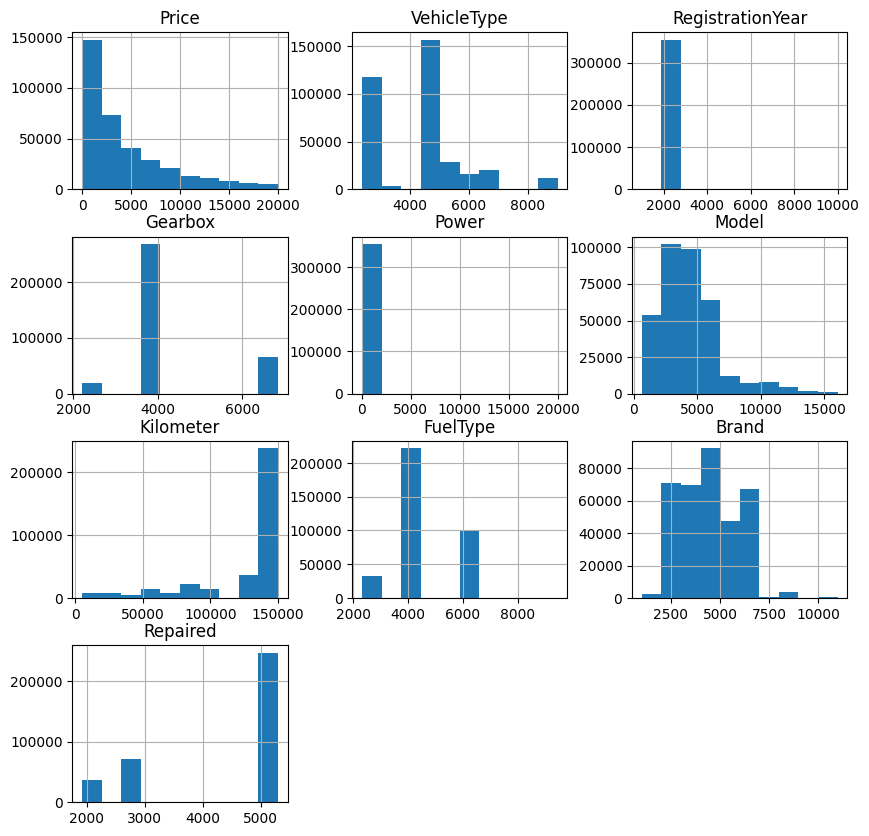

In [ ]:
df_coded.hist(figsize=(10,10))
plt.show

<Axes: >

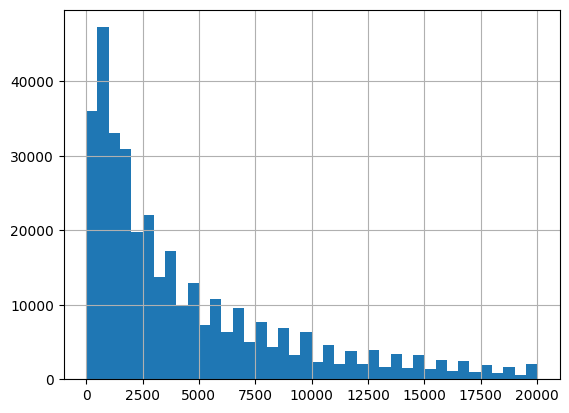

In [ ]:
df_coded['Price'].hist(bins=40)

<function matplotlib.pyplot.show(close=None, block=None)>

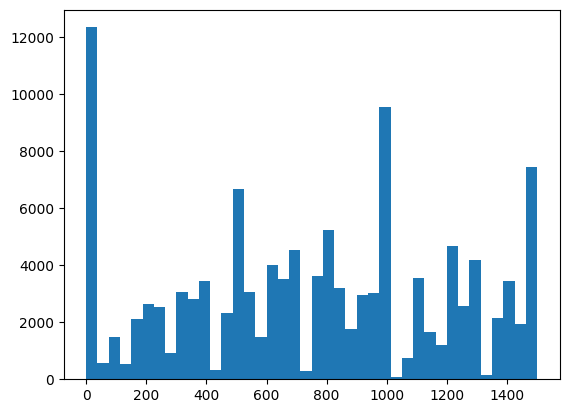

In [ ]:
plt.hist(df_coded['Price'], range=(0,1500), bins=40)
plt.show

In [ ]:
df_coded[df_coded['Price']<100].sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
124564,1,0,2013,0,0,11429.414367,50000,3750.044856,4084.771485,0
261761,0,0,2017,3980.777632,193,5785.723329,150000,3750.044856,6239.914610,5296.852454
248497,0,4880.383308,1997,3980.777632,165,5785.723329,150000,3750.044856,6239.914610,5296.852454
183482,1,2677.694238,1995,3980.777632,90,1892.37409,150000,3750.044856,2730.809769,5296.852454
79536,0,4722.657151,2004,0,0,4154.315831,150000,0,4381.308463,0


In [ ]:
df_coded = df_coded[df_coded['Price']>99]

In [ ]:
df_coded[df_coded['RegistrationYear'] > 2020].sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
134856,11111,0,7000,0,0,2525.965767,10000,0,4381.308463,0
306578,350,0,9999,0,0,6005.421399,10000,0,4381.308463,0
18259,300,0,2200,0,0,1383.230052,5000,0,2269.746970,0
316079,500,0,5555,0,0,2152.585757,10000,0,2269.746970,0
53678,7999,0,5911,6842.136831,75,4154.315831,10000,0,4381.308463,0


In [ ]:
df_coded = df_coded.loc[(df_coded['RegistrationYear']>1900)&(df_coded['RegistrationYear']<2017)]

<function matplotlib.pyplot.show(close=None, block=None)>

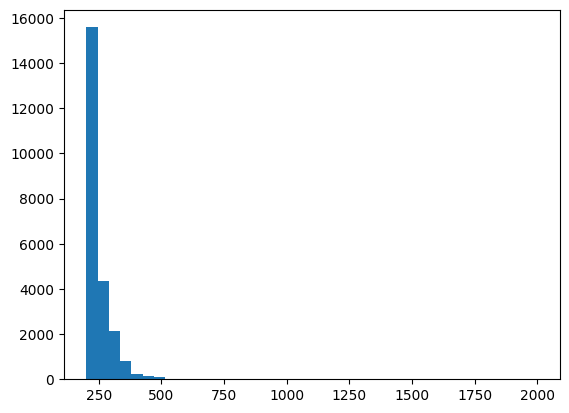

In [ ]:
plt.hist(df_coded['Power'], bins=40, range=(200, 2000))
plt.show

In [ ]:
df_coded = df_coded[(df_coded['Power']<351)&(df_coded['Power']>10)]

In [ ]:
df_coded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294403 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             294403 non-null  int64  
 1   VehicleType       294403 non-null  object 
 2   RegistrationYear  294403 non-null  int64  
 3   Gearbox           294403 non-null  object 
 4   Power             294403 non-null  int64  
 5   Model             294403 non-null  object 
 6   Kilometer         294403 non-null  int64  
 7   FuelType          294403 non-null  object 
 8   Brand             294403 non-null  float64
 9   Repaired          294403 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 24.7+ MB


In [ ]:
df_orig = pd.read_csv('/content/autos.csv')

1 - len(df_coded)/len(df_orig)

0.16921909083469489

<Axes: >

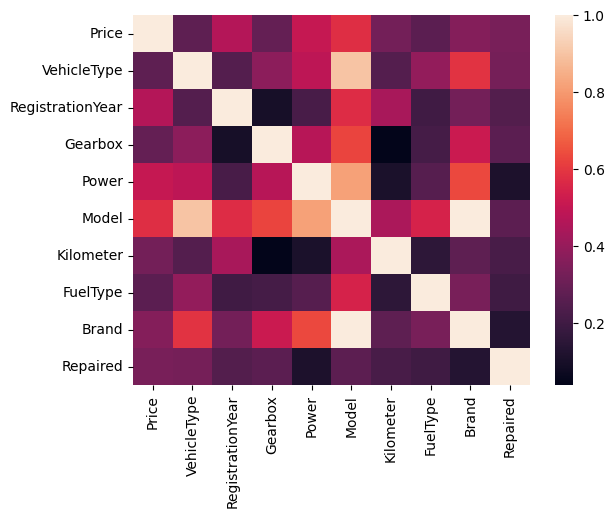

In [ ]:
sns.heatmap(df_coded.phik_matrix(interval_cols=['Price', 'RegistrationYear', 'Power', 'Kilometer']))

Видим что столбец `Модель` коррелирует - сразу с тремя столбцами: `Бренд`, `Тип двигателя` и `Мощность`.  
Возможно от столбца Модель вообще можно отказаться

**Итоги предобработки**  
Мы проверили данные на дубликаты, подозрительные выбросы, а также заполнили пропуски подходящими значениями с помощью KNN Imputer и посмотрели корреляцию

## Обучение моделей

In [ ]:
features = df_coded.drop('Price', axis=1)
target = df_coded['Price']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4,
                                                                           random_state=seed)
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, test_size=0.5,
                                                                           random_state=seed)

In [ ]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((176641, 9), (176641,), (58881, 9), (58881,), (58881, 9), (58881,))

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

Linear Regression

In [ ]:
start_time = time.time()
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_rmse = mse(target_valid, lr.predict(features_valid), squared=False)
lr_time = time.time() - start_time
print(f'Модель: {lr}, rmse: {lr_rmse}, time :{lr_time}')

Модель: LinearRegression(), rmse: 2790.7991227205293, time :0.11708545684814453


DecisionTreeRegressor

In [ ]:
dt = None
dt_rmse = 2500

for depth in tqdm(range (6,25,3)):
    start_time=time.time()
    model = DecisionTreeRegressor(random_state=seed, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = mse(target_valid, predictions, squared=False)
    print("max_depth =", depth, ":", result)
    print(time.time()-start_time)
    if result < dt_rmse:
        dt_rmse = result
        dt = model
        dt_time = time.time() - start_time


 14%|█▍        | 1/7 [00:00<00:02,  2.97it/s]

max_depth = 6 : 2244.648629103646
0.33615875244140625


 29%|██▊       | 2/7 [00:00<00:02,  2.32it/s]

max_depth = 9 : 1995.005395901193
0.4949347972869873


 43%|████▎     | 3/7 [00:01<00:02,  1.95it/s]

max_depth = 12 : 1878.9075234777422
0.6098434925079346


 57%|█████▋    | 4/7 [00:02<00:01,  1.69it/s]

max_depth = 15 : 1867.1286560200908
0.7077772617340088


 71%|███████▏  | 5/7 [00:02<00:01,  1.50it/s]

max_depth = 18 : 1920.9319841937358
0.7996118068695068


 86%|████████▌ | 6/7 [00:03<00:00,  1.36it/s]

max_depth = 21 : 1955.4017930611808
0.8629701137542725


100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

max_depth = 24 : 1975.7348827809394
0.9387967586517334


In [ ]:
print(f'Модель: {dt}, rmse: {dt_rmse}, time :{dt_time}')

Модель: DecisionTreeRegressor(max_depth=15), rmse: 1867.1286560200908, time :0.7078068256378174


RandomForestRegressor



In [ ]:
grid_rf = {
    'max_depth' : list(range(16,22,1)),
    'n_estimators' : list(range(200, 501, 100))
}

In [ ]:
rf = RandomForestRegressor(random_state=seed)
gs_rf = GridSearchCV(
    rf,
    grid_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv = 3
)
gs_rf.fit(features_train, target_train)

print("tuned hyperparameters :(best parameters) ", gs_rf.best_params_)
print("f1 :", gs_rf.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


tuned hyperparameters :(best parameters)  {'max_depth': 18, 'n_estimators': 400}
f1 : -1576.831961574142


LGBMRegressor

In [ ]:
grid_lgbm = {
    'learning_rate' : list(np.arange(0.1,1.1,0.1)),
    'max_depth' : list(range(5, 22, 4))
}

In [ ]:
%%time
lgbm = LGBMRegressor(random_state=seed)

gs_lgbm = GridSearchCV(
    lgbm,
    grid_lgbm,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv = 3
)

gs_lgbm.fit(features_train, target_train)

print("tuned hyperparameters :(best parameters) ", gs_lgbm.best_params_)
print("f1 :", gs_lgbm.best_score_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 176641, number of used features: 9
[LightGBM] [Info] Start training from score 4849.951416
tuned hyperparameters :(best parameters)  {'learning_rate': 0.30000000000000004, 'max_depth': 13}
f1 : -1586.2686277566465
CPU times: user 2.69 s, sys: 242 ms, total: 2.93 s
Wall time: 1min 7s


CatBoostRegressor

In [ ]:
features_train = pd.DataFrame(features_train, columns = features.columns)
features_train[cat] = features_train[cat].astype(str)

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176641 entries, 0 to 176640
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VehicleType       176641 non-null  object 
 1   RegistrationYear  176641 non-null  float64
 2   Gearbox           176641 non-null  object 
 3   Power             176641 non-null  float64
 4   Model             176641 non-null  object 
 5   Kilometer         176641 non-null  float64
 6   FuelType          176641 non-null  object 
 7   Brand             176641 non-null  object 
 8   Repaired          176641 non-null  object 
dtypes: float64(3), object(6)
memory usage: 12.1+ MB


In [ ]:
features_valid = pd.DataFrame(features_valid, columns = features.columns)
features_valid[cat] = features_valid[cat].astype(str)

In [ ]:
cb = CatBoostRegressor(iterations=150, random_seed=seed,
                            verbose=150)

In [ ]:
grid_cb = {
    'learning_rate' : list(np.arange(0.1,1.1,0.1)),
    'max_depth' : list(range(6, 23, 4))
}

In [ ]:
%%time

gs_cb = GridSearchCV(
    cb,
    grid_cb,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv = 3
)

gs_cb.fit(features_train, target_train)

print("tuned hyperparameters :(best parameters) ", gs_cb.best_params_)
print("f1 :", gs_cb.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", lin

0:	learn: 3900.6245421	total: 255ms	remaining: 38.1s
149:	learn: 1286.8481269	total: 39s	remaining: 0us
tuned hyperparameters :(best parameters)  {'learning_rate': 0.2, 'max_depth': 14}
f1 : -1548.0531998046724
CPU times: user 1min 31s, sys: 18.3 s, total: 1min 49s
Wall time: 30min 53s


(best parameters)  {'learning_rate': 0.2, 'max_depth': 14}
f1 : -1548.0531998046724

## Анализ моделей

In [ ]:
features_test_cb = pd.DataFrame(features_test, columns = features.columns)
features_test_cb[cat] = features_test_cb[cat].astype(str)

In [ ]:
cb_rmse = mse(target_test, gs_cb.predict(features_test_cb), squared=False)

In [ ]:
cb_rmse

1479.2070205045322

In [ ]:
lgbm_rmse = mse(target_test, gs_lgbm.predict(features_test), squared=False)
lgbm_rmse

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


1583.1981871191952

In [ ]:
rf_rmse = mse(target_test, gs_rf.predict(features_test), squared=False)
rf_rmse

1303.3425606220603

In [ ]:
dummy_rmse = mse(target_test, pd.Series(target_test.mean(), index = target_test.index), squared=False)

In [120]:
dummy_rmse

4583.931678652258

Посмотрим на результаты моделей в сравнении с временем обучения

In [121]:
models_list = ['Random Forest', 'LGBM', 'CatBoost']

total = pd.DataFrame({'RMSE' : pd.Series([rf_rmse, lgbm_rmse, cb_rmse], index=models_list),
                      'Time' : pd.Series([114, 2, 30], index=models_list)},
                     columns=['RMSE', 'Time'])
total

,RMSE,Time
Random Forest,1303.342561,114
LGBM,1583.198187,2
CatBoost,1479.207021,30


## Выводы

Для решения данной задачи были проведены следующие мероприятия:
* Предобработка данных
	* удаление дубликатов
	* заполнение пропусков с помощью KNN Imputer
	* обработка аномалий
* Обучение моделей:
	* Линейная Регрессия
	* RandomForest Regressor
	* CatBoost Regressor
	* LGBM Regressor

**Для проверки на тестовой выборке были отобраны 3 модели с лучшими результатами, все они показали себя примерно одинаково.  
Также была проведена проверка на адекватность**

In [122]:
total

,RMSE,Time
Random Forest,1303.342561,114
LGBM,1583.198187,2
CatBoost,1479.207021,30


**Параметры рекомендуемых моделей:**  
>RandomForestRegressor (max_depth=18, n_estimators=400)  
>CatBoostRegressor (iterations=150, learning_rate=0.2, max_depth=14)  
>LGBMRegressor ('learning_rate': 0.3, 'max_depth': 13)